## Tests for *intertrain* module

> Fast multidimensional function interpolation by Chebyshev polynomials in the dense (numpy) or sparse (tensor train (TT) with cross approximation) format using Fast Fourier Transform (FFT).

In [1]:
import sys
import time

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import tt

sys.path.append('./../lib')
from intertrain import Intertrain, interpolate, polynomials

---

### Construction of Chebyshev polynomials

#### Chebyshev polynomials on the single point

In [2]:
T = polynomials(X=2., m=4)
print(T.shape, T)

(5,) [ 1.  2.  7. 26. 97.]


#### Chebyshev polynomials on the simple mesh

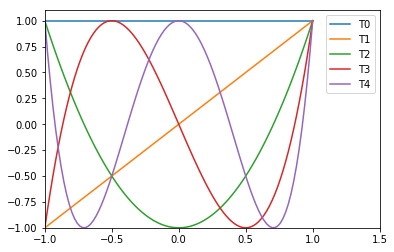

In [3]:
m = 5
X = np.linspace(-1., 1., 100)
T = polynomials(X, m)

for i in range(m):
    plt.plot(X, T[i, :], label='T%d'%i)
    
plt.xlim(-1., 1.5)
plt.ylim(-1., 1.1)
plt.legend(loc='best')
plt.show()

#### Chebyshev polynomials on the multidimensional mesh

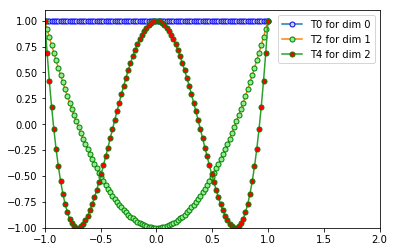

In [7]:
m = 5
X = np.linspace(-1., 1., 100)
X = np.vstack([X, X, X])
T = polynomials(X, m)

plt.plot(
    X[0, :], T[0, 0, :], label='T0 for dim 0',
    marker='o', markersize=5, markerfacecolor='lightgrey', markeredgecolor='b'
)
plt.plot(
    X[1, :], T[2, 1, :], label='T2 for dim 1',
    marker='o', markersize=5, markerfacecolor='lightgreen', markeredgecolor='g'
)
plt.plot(
    X[2, :], T[4, 2, :], label='T4 for dim 2',
    marker='o', markersize=5, markerfacecolor='red', markeredgecolor='g'
)
    
plt.xlim(-1., 2.0)
plt.ylim(-1., 1.1)
plt.legend(loc='best')
plt.show()

---

### Direct construction of 1D Chebyshev interpolation

#### Direct construction of 1D Chebyshev interpolation for one function

Max relative error for interpolation nodes 1.33e-15


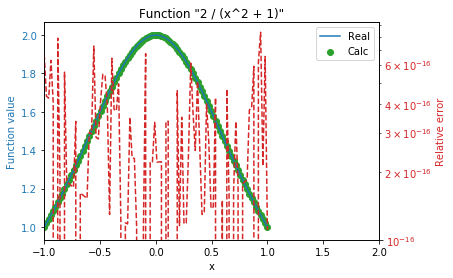

In [9]:
def f(x):
    return 2. / (x**2 + 1)

n = 200
N = n - 1
j = np.arange(n)
x = np.cos(np.pi * j / N)
u = f(x)
a = interpolate(u)

u = u.reshape(-1, 1)
v = polynomials(x, N).T@a
e = np.abs((v - u)/u)
e = np.max(np.abs(e))
print('Max relative error for interpolation nodes %-8.2e'%e)

x = np.linspace(-1., 1., 100)
u = f(x).reshape(-1, 1)
v = polynomials(x, N).T@a
e = np.abs((v - u)/u)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_title('Function "2 / (x^2 + 1)"')
ax1.set_xlabel('x')
ax1.set_xlim(-1, 2)

color = 'tab:blue'
ax1.set_ylabel('Function value', color=color)
ax1.plot(x, u, color=color, label='Real')
ax1.scatter(x, v, color='tab:green', label='Calc')
ax1.tick_params(axis='y', which='both', labelcolor=color)
ax1.legend(loc='best')

color = 'tab:red'
ax2.set_ylabel('Relative error', color=color)
ax2.plot(x, e, '--', color=color)
ax2.tick_params(axis='y', which='both', labelcolor=color)
ax2.semilogy()

plt.show()

#### Direct construction of 1D Chebyshev interpolation for several functions

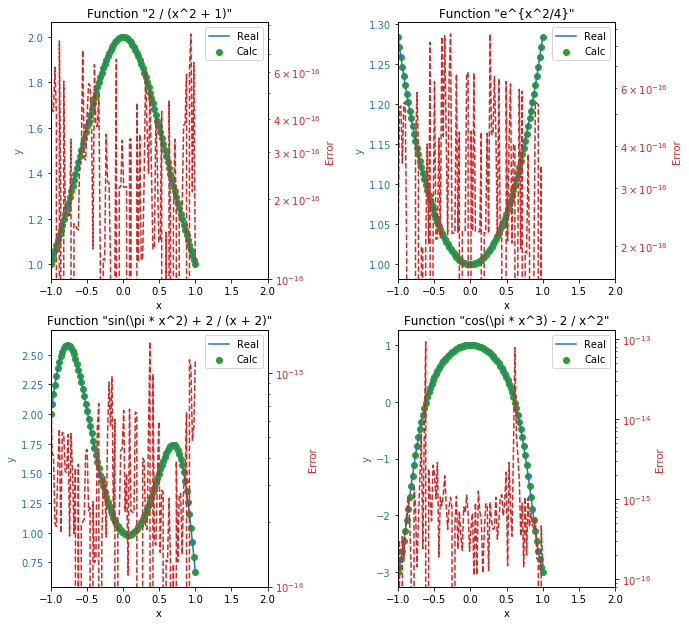

In [10]:
def f1(x): return 2. / (x**2 + 1)
def f2(x): return np.exp(x**2 / 4.)
def f3(x): return np.sin(np.pi * x**2) + 2. / (x + 2.)
def f4(x): return np.cos(np.pi * x**3) - 2. * x**2

funcs = [
    '2 / (x^2 + 1)',
    'e^{x^2/4}',
    'sin(\pi * x^2) + 2 / (x + 2)',
    'cos(\pi * x^3) - 2 / x^2',
]

n = 200
N = n - 1
j = np.arange(n)
x = np.cos(np.pi * j / N)
u1 = f1(x).reshape(-1, 1)
u2 = f2(x).reshape(-1, 1)
u3 = f3(x).reshape(-1, 1)
u4 = f4(x).reshape(-1, 1)
a = interpolate(np.hstack([u1, u2, u3, u4]))

fig = plt.figure(figsize=(8, 8))
gs = mpl.gridspec.GridSpec(
    ncols=2, nrows=2, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.6, hspace=0.2, width_ratios=[1, 1], height_ratios=[1, 1]
)

x = np.linspace(-1., 1., 100)

for k in range(len(funcs)):
    i = int(k / 2)
    j = k - 2*i
    
    u = eval('f%d'%(k+1))(x)
    v = polynomials(x, N).T@a[:, k]
    e = np.abs((v - u)/u)

    ax1 = fig.add_subplot(gs[i, j])
    ax2 = ax1.twinx()
    
    ax1.set_title('Function "%s"'%funcs[k])
    ax1.set_xlabel('x')
    ax1.set_xlim(-1, 2)

    color = 'tab:blue'
    ax1.set_ylabel('y', color=color)
    ax1.plot(x, u, color=color, label='Real')
    ax1.scatter(x, v, color='tab:green', label='Calc')
    ax1.tick_params(axis='y', which='both', labelcolor=color)
    ax1.legend(loc='best')

    color = 'tab:red'
    ax2.set_ylabel('Error', color=color)
    ax2.plot(x, e, '--', color=color)
    ax2.tick_params(axis='y', which='both', labelcolor=color)
    ax2.semilogy()

plt.show()

#### Complexity estimation of 1D Chebyshev interpolation for several functions

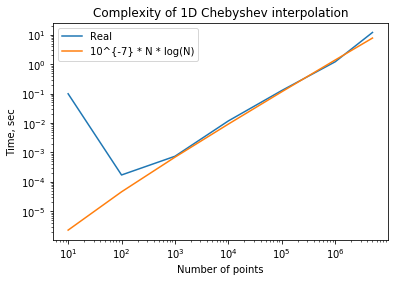

In [12]:
def f(x):
    return np.exp(x**2 / 4.)

k = 10
N = np.array([1E1, 1E2, 1E3, 1E4, 1E5, 1E6, 5E6])
T = np.array([])

for n in N:
    j = np.arange(n)
    x = np.cos(np.pi * j / (n-1))
    u = f(x).reshape(-1, 1)
    t = time.time()
    a = interpolate(np.repeat(u, k, axis=1))
    T = np.append(T, [time.time()-t])

C = N * np.log(N)/1.0E7

plt.plot(N, T, label='Real')
plt.plot(N, C, label='10^{-7} * N * log(N)')
plt.title('Complexity of 1D Chebyshev interpolation')
plt.xlabel('Number of points')
plt.ylabel('Time, sec')
plt.semilogx()
plt.semilogy()
plt.legend(loc='best')
plt.show()

---

### Tests for interpolation by Chebyshev polynomials in the TT-format with cross approximation

Let consider 4D function of the form

$$
f(x) = 7 + x_1^2 + e^{-x_2} + \sin{x_3} + x_4^3
$$

In [13]:
def func(x):
    return 7. + x[0, ]**2 + np.exp(-x[1, ]) + np.sin(x[2, ]) + x[3, ]**3

In [14]:
IT = Intertrain(
    n=[20, 22, 24, 26],
    l=[ [-3., 3.], [-2., 2.], [-4., 4.], [-1., 1.] ],
    eps=1.E-6
)

### Interpolation with cross approximation

In [4]:
IT.init(func)
IT.prep()
IT.info()

------------------ Parameters
Dimensions       :        4
Accuracy         : 1.00e-06
Dim 1  | Poi 20  | Min -3.000 | Max 3.000  |
Dim 2  | Poi 22  | Min -2.000 | Max 2.000  |
Dim 3  | Poi 24  | Min -4.000 | Max 4.000  |
Dim 4  | Poi 26  | Min -1.000 | Max 1.000  |
------------------ Result (cross appr)
Func. evaluations:     6408
Cross iterations :        3
Av. tt-rank      : 7.70e+00
Cross err (rel)  : 4.10e-16
Cross err (abs)  : 3.10e-12
------------------ Test (random points)
Number of points : 10
Error (max)      : 1.17e-15 
Error (mean)     : 8.11e-16 
Error (min)      : 4.52e-16 
------------------ Time
Init             : 8.76e-02 sec. 
Prep             : 1.61e-02 sec. 
Calc (average)   : 2.06e-03 sec. 
Func (average)   : 9.37e-07 sec. 
------------------


### Interpolation from explicit tensor of function values

In [5]:
Y = np.zeros(IT.n)
for ind, v in np.ndenumerate(Y):
    Y[ind] = func(IT.point(np.array(ind)))
Y = tt.tensor(Y, IT.eps)

IT.init(Y=Y)
IT.prep()
IT.info(func)

------------------ Parameters
Dimensions       :        4
Accuracy         : 1.00e-06
Dim 1  | Poi 20  | Min -3.000 | Max 3.000  |
Dim 2  | Poi 22  | Min -2.000 | Max 2.000  |
Dim 3  | Poi 24  | Min -4.000 | Max 4.000  |
Dim 4  | Poi 26  | Min -1.000 | Max 1.000  |
------------------ Result (cross appr)
Func. evaluations:        0
Cross iterations :        0
Av. tt-rank      : 0.00e+00
Cross err (rel)  : 0.00e+00
Cross err (abs)  : 0.00e+00
------------------ Test (random points)
Number of points : 10
Error (max)      : 1.92e-15 
Error (mean)     : 1.02e-15 
Error (min)      : 4.10e-16 
------------------ Time
Init             : 8.82e-06 sec. 
Prep             : 6.95e-04 sec. 
Calc (average)   : 4.13e-04 sec. 
Func (average)   : 0.00e+00 sec. 
------------------
